# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

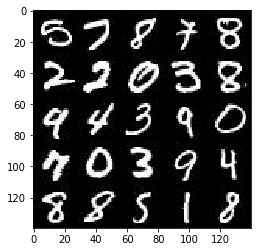

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

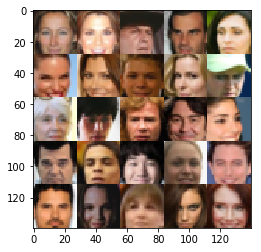

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tensor_input_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    tensor_z = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32, None)
    return tensor_input_images, tensor_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse = reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        print(relu1.shape)

        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        print(relu2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=1, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        print(relu3.shape)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        print(out.shape)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse = not is_train) as scope:
        alpha = 0.2
        # Fully connected
        fully_connected = tf.layers.dense(z, 4*4*512)
        # 1st layer 
        x1 = tf.reshape(fully_connected, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training = True)
        relu1 = tf.maximum(alpha*bn1, bn1)
        print(relu1.shape)

        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        print(relu2.shape)


        x3 = tf.layers.conv2d_transpose(relu2, 128, 4, strides=2, padding ='same')
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        print(relu3.shape)


        # Ouput layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 4, strides=2, padding='SAME')

        out = tf.tanh(logits)
        print(out.shape)

    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 4)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, width, height, depth = data_shape
    tensor_input_images, tensor_z, learning_rate_parameter = model_inputs(width, height, depth, z_dim)    
    d_loss, g_loss = model_loss(tensor_input_images, tensor_z, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_parameter, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizer
                _ = sess.run(d_opt, feed_dict={tensor_input_images: batch_images,
                                               tensor_z: batch_z,
                                               learning_rate_parameter: learning_rate})
                _ = sess.run(g_opt, feed_dict={tensor_input_images: batch_images,
                                               tensor_z: batch_z,
                                               learning_rate_parameter: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({tensor_input_images: batch_images,
                                               tensor_z: batch_z,
                                               learning_rate_parameter: learning_rate})
                    train_loss_g = g_loss.eval({tensor_input_images: batch_images,
                                               tensor_z: batch_z,
                                               learning_rate_parameter: learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, tensor_z, depth, data_image_mode)
                    
    return losses
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Epoch 1/2... Discriminator Loss: 2.4206... Generator Loss: 6.6317
Epoch 1/2... Discriminator Loss: 2.5939... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 2.7335... Generator Loss: 0.1302
Epoch 1/2... Discriminator Loss: 2.1414... Generator Loss: 0.2557
Epoch 1/2... Discriminator Loss: 2.0206... Generator Loss: 0.2496
Epoch 1/2... Discriminator Loss: 2.0121... Generator Loss: 0.2452
Epoch 1/2... Discriminator Loss: 2.0219... Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 1.9754... Generator Loss: 0.2434
Epoch 1/2... Discriminator Loss: 1.9487... Generator Loss: 0.2687
Epoch 1/2... Discriminator Loss: 1.7690... Generator Loss: 0.3361
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


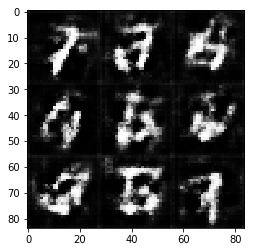

Epoch 1/2... Discriminator Loss: 1.9214... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 1.9304... Generator Loss: 0.2565
Epoch 1/2... Discriminator Loss: 2.0005... Generator Loss: 0.2462
Epoch 1/2... Discriminator Loss: 1.9171... Generator Loss: 0.2619
Epoch 1/2... Discriminator Loss: 1.7262... Generator Loss: 0.3502
Epoch 1/2... Discriminator Loss: 1.9627... Generator Loss: 0.2509
Epoch 1/2... Discriminator Loss: 1.6488... Generator Loss: 0.3751
Epoch 1/2... Discriminator Loss: 1.8602... Generator Loss: 0.3357
Epoch 1/2... Discriminator Loss: 2.0030... Generator Loss: 0.2596
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.4950
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


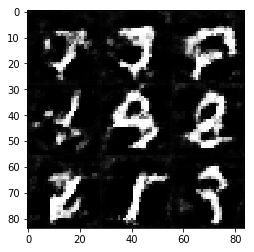

Epoch 1/2... Discriminator Loss: 1.8330... Generator Loss: 0.3951
Epoch 1/2... Discriminator Loss: 1.2817... Generator Loss: 0.8645
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 2.8147... Generator Loss: 0.1200
Epoch 1/2... Discriminator Loss: 1.7045... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.0288
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.3540
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.4925
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


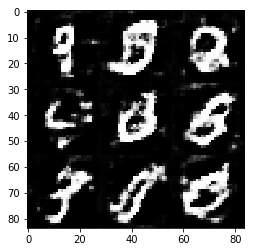

Epoch 1/2... Discriminator Loss: 1.5549... Generator Loss: 0.4527
Epoch 1/2... Discriminator Loss: 1.4202... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.7986... Generator Loss: 0.3253
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 2.5751... Generator Loss: 2.8887
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.4132
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 1.6548
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 1.7001
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


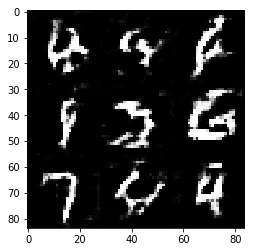

Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.5482
Epoch 1/2... Discriminator Loss: 0.9359... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.6333
Epoch 1/2... Discriminator Loss: 1.1899... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.8144... Generator Loss: 2.5565
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.6450... Generator Loss: 2.6537
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 1.9652
Epoch 2/2... Discriminator Loss: 0.9343... Generator Loss: 1.5790
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


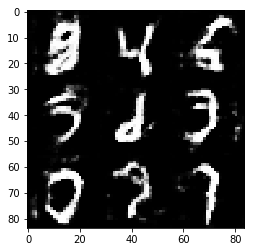

Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.3211
Epoch 2/2... Discriminator Loss: 2.4899... Generator Loss: 0.1657
Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 0.5365
Epoch 2/2... Discriminator Loss: 1.7668... Generator Loss: 2.8239
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.4513
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 1.5214
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.9686
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


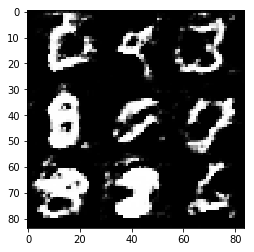

Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.6376
Epoch 2/2... Discriminator Loss: 0.8423... Generator Loss: 1.4967
Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 3.3232... Generator Loss: 4.1834
Epoch 2/2... Discriminator Loss: 1.0147... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 0.7345... Generator Loss: 1.7693
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.2597
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


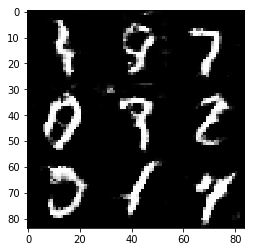

Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.5184
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.6978
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.4086
Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.6889
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 2.1113
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 1.7405
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 0.9902
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


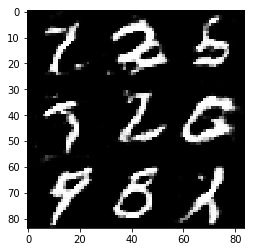

Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.7964
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 2.6939
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 1.9558
Epoch 2/2... Discriminator Loss: 2.1810... Generator Loss: 0.3386
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 1.7507
Epoch 2/2... Discriminator Loss: 3.2634... Generator Loss: 0.1062
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.5748
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 1.0496
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 1)


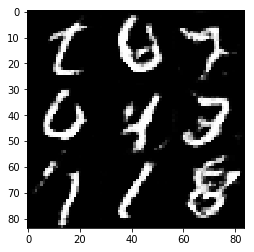

Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.3142
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 2.1808
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.7521


In [13]:
batch_size = 128
z_dim = 500
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
(?, 14, 14, 64)
(?, 7, 7, 128)
(?, 4, 4, 256)
(?, 1)
Epoch 1/1... Discriminator Loss: 5.5509... Generator Loss: 0.0572
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 4.4620... Generator Loss: 5.7979
Epoch 1/1... Discriminator Loss: 2.1254... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 3.7763... Generator Loss: 0.0968
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 2.4696
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 2.3252... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 2.5559... Generator Loss: 2.0642
Epoch 1/1... Discriminator Loss: 1.9391... Generator Loss: 0.2665
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


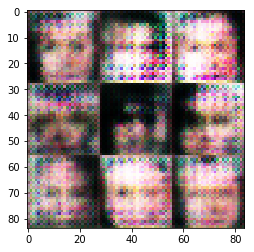

Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.8335... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 2.4005... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 1.6930... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 2.0657... Generator Loss: 1.7102
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.3584
Epoch 1/1... Discriminator Loss: 1.7749... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 1.0129
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


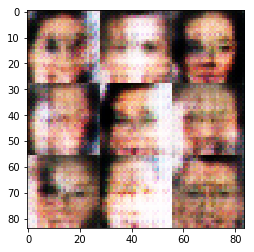

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.9774... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.6901... Generator Loss: 0.5170
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


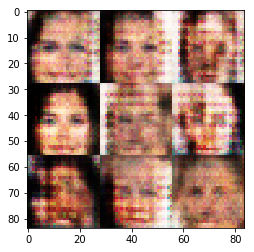

Epoch 1/1... Discriminator Loss: 1.7709... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 2.0639... Generator Loss: 0.2580
Epoch 1/1... Discriminator Loss: 1.7708... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 3.1691... Generator Loss: 2.3437
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 1.0089
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


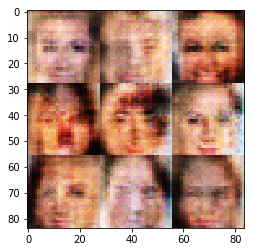

Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.6300... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.8075... Generator Loss: 0.3950
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


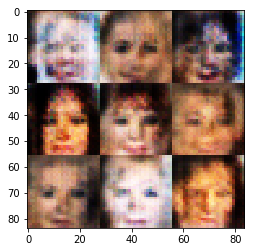

Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.8739... Generator Loss: 0.3262
Epoch 1/1... Discriminator Loss: 2.2973... Generator Loss: 0.1858
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.8841... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.3729
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


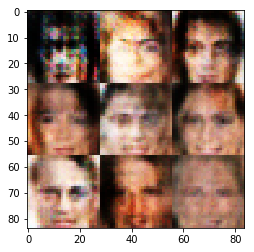

Epoch 1/1... Discriminator Loss: 1.8585... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.5985... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.4440
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


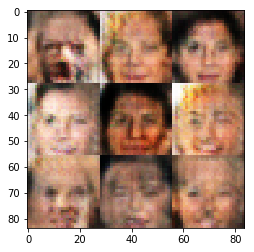

Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.7751... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.8239... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7558
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


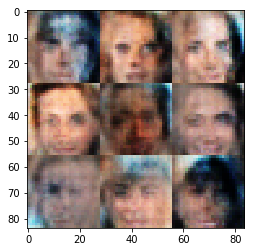

Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.6938... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 2.1792... Generator Loss: 0.2109
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.9370
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


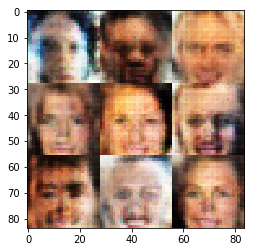

Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.4748
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


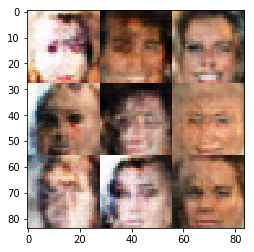

Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.6794... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.7592... Generator Loss: 0.3297
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.4057
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


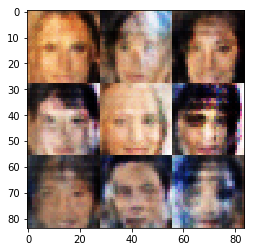

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.6126... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 1.1179
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.4522
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


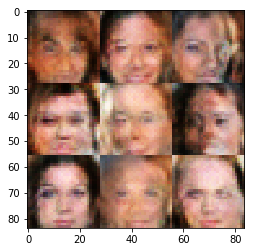

Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 1.9303... Generator Loss: 0.2698
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


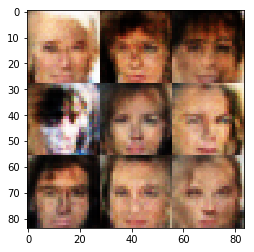

Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.7300... Generator Loss: 0.3132
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.8359... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7093
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


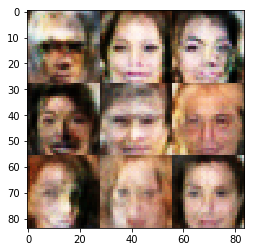

Epoch 1/1... Discriminator Loss: 2.0175... Generator Loss: 0.2498
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.7956... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 1.0787
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


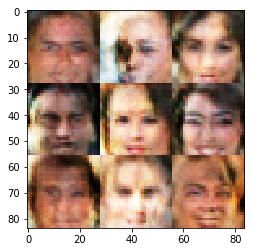

Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.6354... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.9377
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


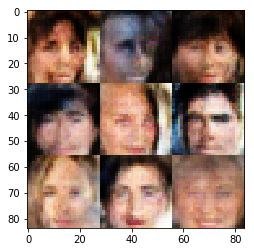

Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.8997... Generator Loss: 0.2665
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.8640... Generator Loss: 0.2939
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


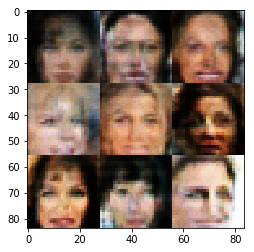

Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.9367... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.8045... Generator Loss: 0.2965
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5368
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


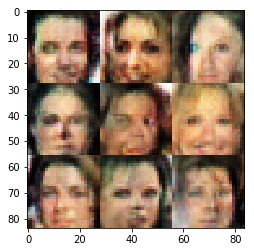

Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.5461... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.5875
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


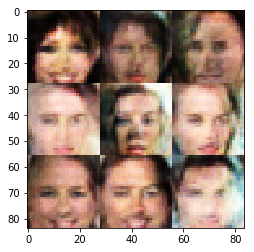

Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.7908... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.7408... Generator Loss: 0.3489
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.7044... Generator Loss: 0.3816
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


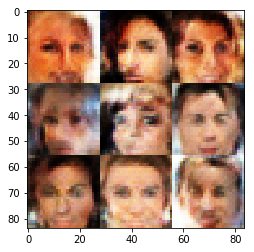

Epoch 1/1... Discriminator Loss: 1.8507... Generator Loss: 0.2955
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.9082... Generator Loss: 0.2647
Epoch 1/1... Discriminator Loss: 1.8651... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4029
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


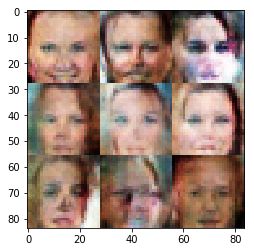

Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 1.0071
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.7878... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.9895... Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.5485
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


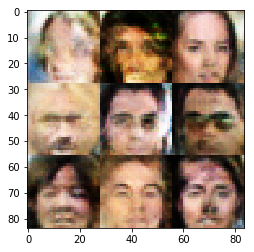

Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.3795
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 0.3950
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 0.2538
Epoch 1/1... Discriminator Loss: 1.7242... Generator Loss: 0.3486
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.9351... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7910
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


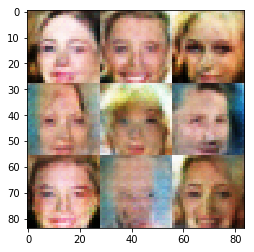

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 1.0597
Epoch 1/1... Discriminator Loss: 1.7721... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.7424... Generator Loss: 0.3480
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


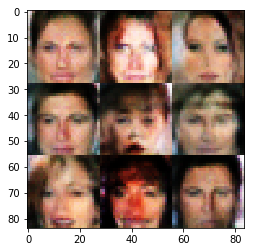

Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 1.9021... Generator Loss: 0.2841
Epoch 1/1... Discriminator Loss: 1.6512... Generator Loss: 0.3898
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.3887
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.1397
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


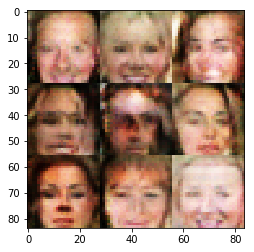

Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.9479... Generator Loss: 0.3137
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4983
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.8329... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.9648... Generator Loss: 0.2602
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8150
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


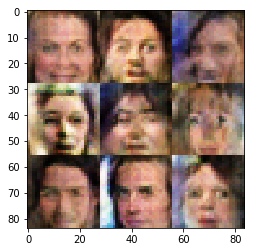

Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4412
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.8118... Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 2.0393... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 1.6537... Generator Loss: 0.3768
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


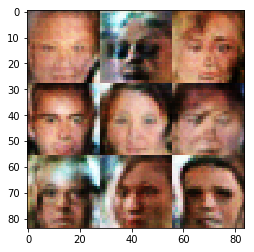

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.7466... Generator Loss: 0.3382
Epoch 1/1... Discriminator Loss: 2.0903... Generator Loss: 0.2620
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.6808... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 2.3679... Generator Loss: 1.7525
Epoch 1/1... Discriminator Loss: 2.0565... Generator Loss: 0.2354
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.1656
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


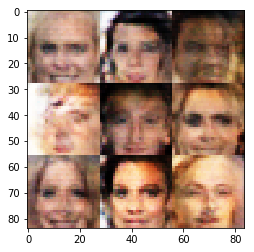

Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.3655
Epoch 1/1... Discriminator Loss: 1.6462... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 1.8403... Generator Loss: 0.3424
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7385
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


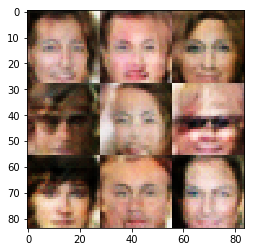

Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 1.8768... Generator Loss: 0.2913
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.8356... Generator Loss: 0.2842
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.9782... Generator Loss: 0.2525
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


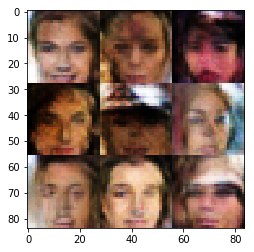

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.3034
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.8952... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 2.1150... Generator Loss: 0.2142
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.6682
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6254
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


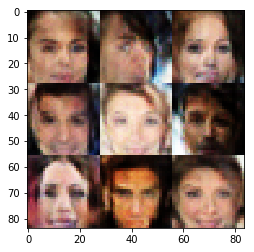

Epoch 1/1... Discriminator Loss: 2.0095... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 1.7593... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 0.4190
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.1762
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


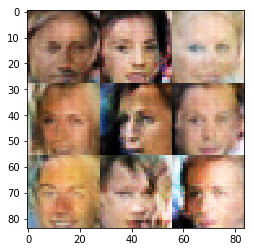

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.8360... Generator Loss: 0.3084
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 2.0258... Generator Loss: 0.2365
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.4609
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


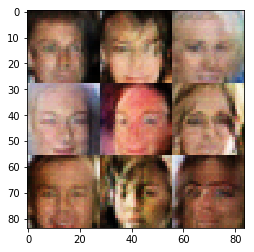

Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.9179... Generator Loss: 0.2723
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.8916... Generator Loss: 0.2684
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.8128... Generator Loss: 0.2979
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


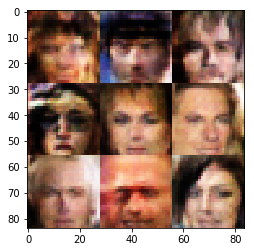

Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.7076... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.6417... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.8237... Generator Loss: 0.2988
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8579
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


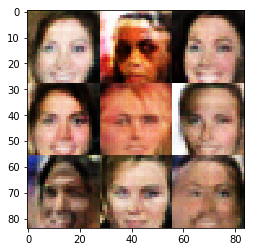

Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.4895
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 1.3403
Epoch 1/1... Discriminator Loss: 2.0496... Generator Loss: 0.2526
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 2.0450... Generator Loss: 0.2107
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


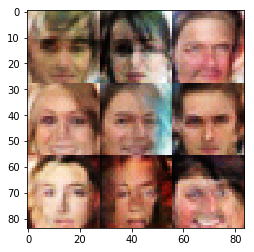

Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.3692
Epoch 1/1... Discriminator Loss: 1.7751... Generator Loss: 0.3295
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


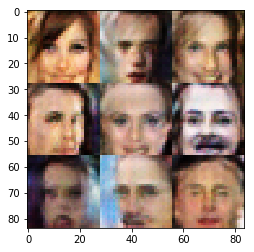

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.9979... Generator Loss: 0.2554
Epoch 1/1... Discriminator Loss: 1.8379... Generator Loss: 0.2950
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 1.8222... Generator Loss: 0.3092
Epoch 1/1... Discriminator Loss: 1.8982... Generator Loss: 0.3033
Epoch 1/1... Discriminator Loss: 2.0807... Generator Loss: 0.2436
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 1.2171
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


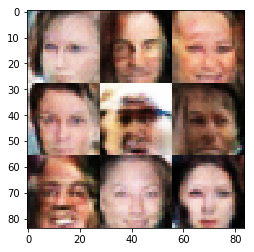

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.6701... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 2.3619... Generator Loss: 0.1796
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.9737... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 2.5916... Generator Loss: 0.1636
Epoch 1/1... Discriminator Loss: 1.7920... Generator Loss: 0.3098
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8196
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


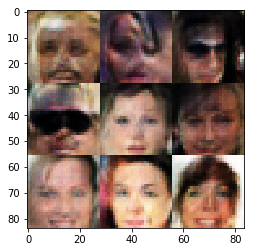

Epoch 1/1... Discriminator Loss: 1.9564... Generator Loss: 0.3308
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.9189... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.8167... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 0.3162
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5494
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


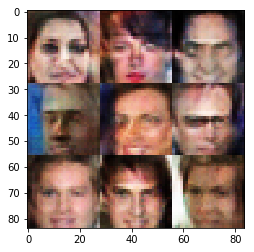

Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.8485... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 2.2417... Generator Loss: 0.3288
Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 1.8819... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 2.1287... Generator Loss: 0.2407
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.8459... Generator Loss: 0.3021
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


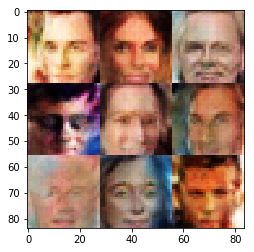

Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 2.0736... Generator Loss: 0.2196
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.8763... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.8618... Generator Loss: 0.3752
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.4276
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


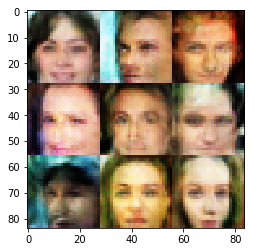

Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.8627... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 1.8807... Generator Loss: 0.3019
Epoch 1/1... Discriminator Loss: 1.9828... Generator Loss: 0.2482
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


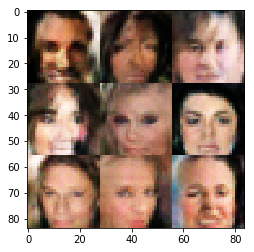

Epoch 1/1... Discriminator Loss: 2.1012... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.8574... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.7833... Generator Loss: 0.3331
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4272
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


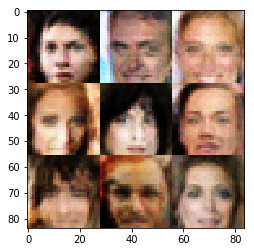

Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 2.2079... Generator Loss: 0.2117
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.3080
Epoch 1/1... Discriminator Loss: 1.9913... Generator Loss: 0.2499
Epoch 1/1... Discriminator Loss: 1.7733... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.9141... Generator Loss: 0.2751
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


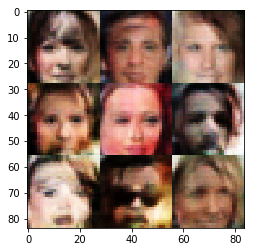

Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 2.5144... Generator Loss: 0.1432
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.8206... Generator Loss: 0.3241
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.6541... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 1.4116
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


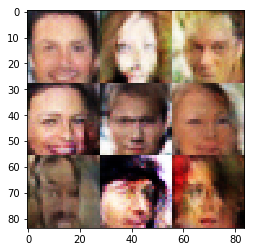

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.7689... Generator Loss: 0.4134
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 2.1443... Generator Loss: 0.2179
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.7845... Generator Loss: 1.1806
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


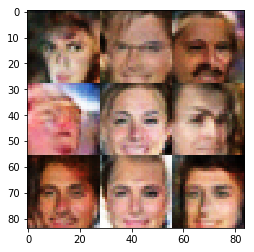

Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 2.2931... Generator Loss: 0.1800
Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.8562... Generator Loss: 0.3044
Epoch 1/1... Discriminator Loss: 1.8193... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5131
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


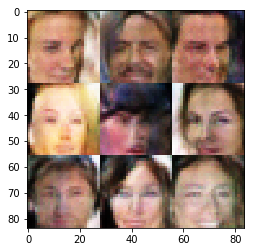

Epoch 1/1... Discriminator Loss: 2.1363... Generator Loss: 0.2163
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.2219
Epoch 1/1... Discriminator Loss: 2.4265... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.5028
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


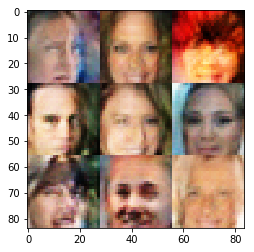

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.7166... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 2.0815... Generator Loss: 0.2732
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 2.1121... Generator Loss: 0.2231
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


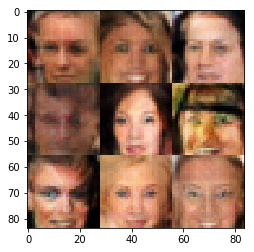

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.8854... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.9641... Generator Loss: 0.2699
Epoch 1/1... Discriminator Loss: 2.1062... Generator Loss: 0.2143
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.3564
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6194
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


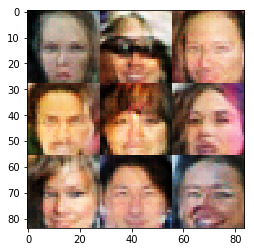

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 2.0356... Generator Loss: 0.2403
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 2.1010... Generator Loss: 0.2157
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.6956... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 2.2904... Generator Loss: 0.1759
Epoch 1/1... Discriminator Loss: 2.5526... Generator Loss: 0.1457
Epoch 1/1... Discriminator Loss: 1.7685... Generator Loss: 0.3380
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.3839
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


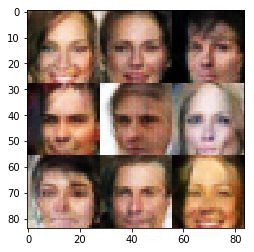

Epoch 1/1... Discriminator Loss: 2.3018... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.8701... Generator Loss: 0.2837
Epoch 1/1... Discriminator Loss: 2.4398... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.4076
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


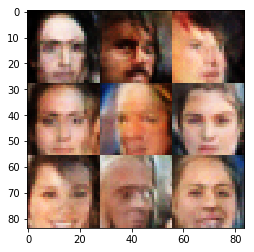

Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6098
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


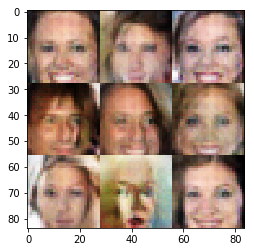

Epoch 1/1... Discriminator Loss: 1.9577... Generator Loss: 0.2876
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4688
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.7736... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4867
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


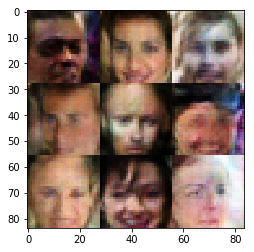

Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.7545... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.8551... Generator Loss: 0.2797
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8607
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


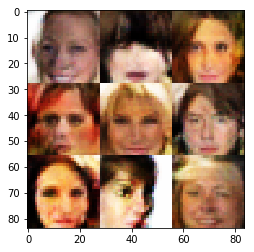

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 1.6556
Epoch 1/1... Discriminator Loss: 1.7034... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.8218... Generator Loss: 0.3226
Epoch 1/1... Discriminator Loss: 2.6762... Generator Loss: 0.1219
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.4718
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


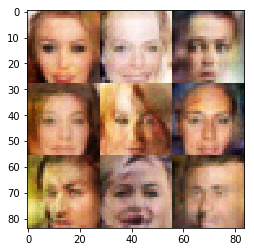

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 2.0192... Generator Loss: 0.2382
Epoch 1/1... Discriminator Loss: 1.9217... Generator Loss: 0.2837
Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 0.3363
Epoch 1/1... Discriminator Loss: 1.7504... Generator Loss: 0.3189
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.4053
Epoch 1/1... Discriminator Loss: 2.1100... Generator Loss: 0.2125
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6073
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


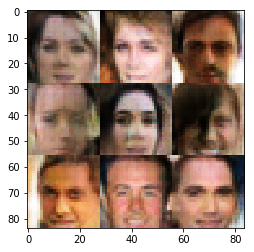

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 2.0984... Generator Loss: 0.2194
Epoch 1/1... Discriminator Loss: 3.0020... Generator Loss: 0.0917
Epoch 1/1... Discriminator Loss: 2.2974... Generator Loss: 0.1934
Epoch 1/1... Discriminator Loss: 1.7509... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.6493... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6697
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


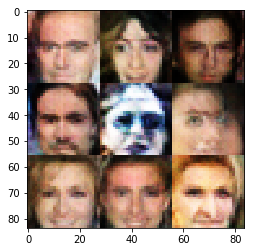

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 2.0888... Generator Loss: 0.2647
Epoch 1/1... Discriminator Loss: 1.8370... Generator Loss: 0.3108
Epoch 1/1... Discriminator Loss: 2.2617... Generator Loss: 0.1933
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.8088... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.3981
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


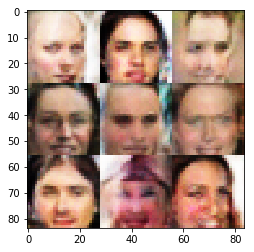

Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 2.0884... Generator Loss: 0.2383
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 2.4234... Generator Loss: 0.1723
Epoch 1/1... Discriminator Loss: 2.6580... Generator Loss: 0.1452
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.8030... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.8301... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 1.8690... Generator Loss: 0.2935
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


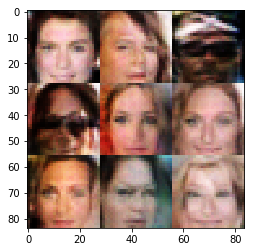

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 0.3104
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.9160... Generator Loss: 0.2923
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.3820
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


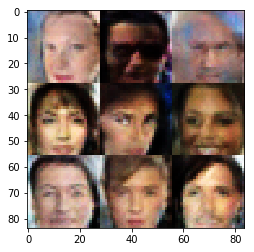

Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.7138... Generator Loss: 2.1397
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9486
(?, 4, 4, 512)
(?, 7, 7, 256)
(?, 14, 14, 128)
(?, 28, 28, 3)


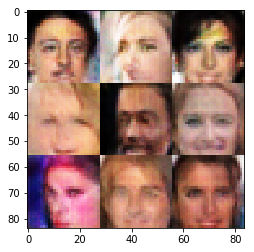

Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.4351
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.7006... Generator Loss: 0.3692


In [14]:
batch_size = 32
z_dim = 500
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.